# next note detector

From the book:
$$p \left( \vec{s}, m, \vec{t}, \vec{p} \right) \\
= A e^{-Cm} \prod_{k=1}^m \frac{1}{Z_k} 
\exp\left( 
- a \left( \sum\limits_{t=t_k}^{t_{k+1}-p_k-1} (s(t + p_k) - s(t)^2) / 2 \right)
- b \left( \sum\limits_{t=t_k}^{t_{k+1}-1} (s(t))^2 / 2 \right)
\right) $$

In this notebook, we will make a next note detector on a snippet of audio, given the knowledge of the period of the pervious note. 

So $m = 2$, with $t_0 = 0$ and $p_0$ known. We will maximise the term dependent on $t_1$ and $p_1$:

$$\exp\left(
- a \left( \sum\limits_{t=0}^{t_1 - 1} [s(t + p_0) - s(t)]^2 / 2 \right)
- b \left( \sum\limits_{t=0}^{t_1 - 1} [s(t)]^2 / 2 \right) 
- a \left( \sum\limits_{t=t_1}^{n-1} [s(t + p_1) - s(t)]^2 / 2 \right)
- b \left( \sum\limits_{t=t_1}^{n-1} [s(t)]^2 / 2 \right)
\right)$$

We can instead minimise the negative log of the expression $f(t_1, p_1)$:

$$a \left( \sum\limits_{t=0}^{t_1 -1} [s(t + p_0) - s(t)]^2 / 2 \right)
+ b \left( \sum\limits_{t=0}^{t_1 -1} [s(t)]^2 / 2 \right) +
a \left( \sum\limits_{t=t_1}^{n-1} [s(t + p_1) - s(t)]^2 / 2 \right)
+ b \left( \sum\limits_{t=t_1}^{n-1} [s(t)]^2 / 2 \right)$$

Since the term based on $b$ does not matter change with either $t_k$ and $p_k$, we shall instead minimise:
$$
a \left( \sum\limits_{t=0}^{t_1 -1} [s(t + p_0) - s(t)]^2 / 2 \right) + 
a \left( \sum\limits_{t=t_1}^{n-1} [s(t + p_1) - s(t)]^2 / 2 \right)
$$

We will plot the range of interest of $z = f(t_1, p_1) = f(x,y)$, which is $500 \leq x < 700$ and $140 \leq y < 160 $.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n = 2048
period_prev = 100

real_start_time = 533
real_period = 44100./300.
print("real period: {}".format(real_period))

real period: 147.0


# defining the signal

### with spliced sine waves

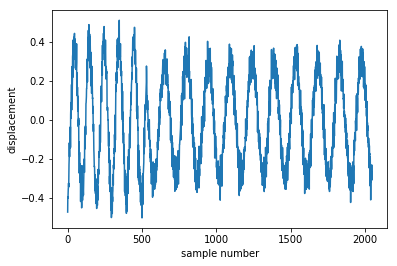

In [41]:
# sine_prev = 0.4*np.sin(2*np.pi/period_prev*np.arange(0,real_start_time)
#                       + np.random.randn())  # to randomise phase
sine_prev[:real_start_time] = [0]*real_start_time
sine_next = 0.3*np.sin(2*np.pi/real_period*np.arange(real_start_time,n)
                      + np.random.randn())  

sine = np.concatenate((sine_prev, sine_next))
# s = np.add(0.05*np.random.randn(n), sine)

plt.plot(s)
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

### importing the signal
suitable signal is necessary, however

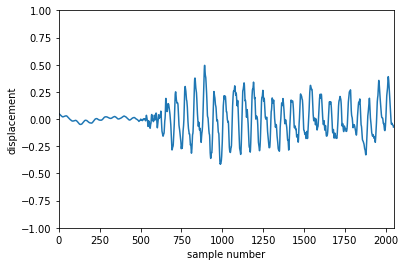

In [4]:
period_prev = 100  # not exactly

import os
import soundfile as sf
# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/marsh mono.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

t_start = 0.65
t_end = 29.0
signal = ref[int(t_start * 44100): int(t_end * 44100), 0]
chunksize = 2048

signal_length = chunksize
# run this once only
entry_start_number = 1748
s = np.array(signal[entry_start_number:entry_start_number+chunksize])

n = chunksize

plt.plot(s)
ax = plt.gca()
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

### using multivar Gaussian

In [5]:
def frequency_modulation(spectrum, freq_profile_):
    #modulation = [np.arctan(x/100.) * np.exp(-x/200.) for x in range(1,n)]
    modulation = freq_profile_
    spectrum = np.multiply(np.abs(spectrum), modulation)
    return spectrum


def complete_magnitude(magnitude):
    # the input is the absolute value, excludes zero at 0 - total of N/2 - 1
    phase = [2 * np.pi * np.random.random() for angle in range(len(magnitude))]
    reals = np.multiply(magnitude, np.sin(np.array(phase)))
    imags = np.multiply(magnitude, np.cos(np.array(phase)))

    fcef = complete_realimags(reals, imags)
    return fcef


def complete_realimags(reals, imags):
    # the input excludes zero at 0 - total of N/2 - 1 entries
    reals = np.concatenate([reals, reals[::-1]])
    reals = np.insert(reals, int(len(reals) / 2), 0)
    reals = np.insert(reals, 0, 0)

    imags = np.concatenate([imags, -1 * np.array(imags[::-1])])
    imags = np.insert(imags, int(len(imags) / 2), 0)
    imags = np.insert(imags, 0, 0)

    fcef = np.vectorize(complex)(reals, imags)
    return fcef

In [6]:
notes_start = [0., 0.5+(real_start_time/44100.), 1]  # start times (the last entry is end time)
notes_freq = [44100./period_prev, 300]  # frequencies of notes
number_of_notes = len(notes_freq)

# signal = np.zeros(int(1+time*sampling_rate))
# signal = [0]*(2*44100)
# window_time = np.sqrt(np.hamming(44100))
window_time = [np.arctan(400.*x) * np.exp(-3.0*x) for x in np.arange(0.,1.,1/44100.)]
# plt.plot(sound)
# plt.show()

b = 0.01
a = 1

N = 44100

freq_profile = [(x / 10.) * np.exp(-x / 400.) for x in range(1, int(N/2))]

In [7]:
# overlap
signal = [0]*(2*44100)

for i in range(number_of_notes):
    
    time = notes_start[i]
    freq = notes_freq[i]
    
    spectrum = [(b + 4*a*((np.sin(np.pi*freqz/freq))**2)) ** -0.5 
                for freqz in range(1, int(N/2))]
    spectrum = np.multiply(spectrum, np.random.randn(22049))
    spectrum = frequency_modulation(spectrum, freq_profile)  # frequency modulation
    fcef = complete_magnitude(spectrum)    
#     plt.plot(spectrum[:1000])
#     plt.show()
    
    sound = np.fft.ifft(fcef).real
    sound = np.multiply(sound, window_time)  # time modulation
    signal[int(time*44100): int(time*44100)+44100] += sound 

In [8]:
# no overlap
signal = [0]*(2*44100)

for i in range(number_of_notes):
        
    time_start = notes_start[i]
    time_end = notes_start[i+1]
    freq = notes_freq[i]
    
    spectrum = [(b + 4*a*((np.sin(np.pi*freqz/freq))**2)) ** -0.5 
                for freqz in range(1, int(N/2))]
    spectrum = np.multiply(spectrum, np.random.randn(22049))
    spectrum = frequency_modulation(spectrum, freq_profile)  # frequency modulation
    fcef = complete_magnitude(spectrum)
#     plt.plot(spectrum[:1000])
#     plt.show()
    
    sound = np.fft.ifft(fcef).real
    sound = np.multiply(sound, window_time)  # time modulation        
    signal[int(time_start*44100.): int(time_end*44100.)] += sound[:int(44100*(time_end))-int(44100*(time_start))]

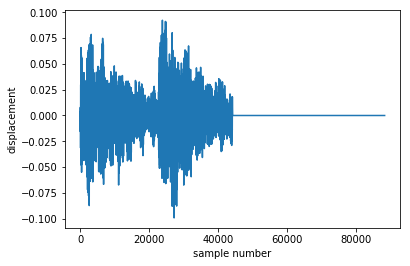

In [9]:
plt.plot(signal)
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

snippet to analyse

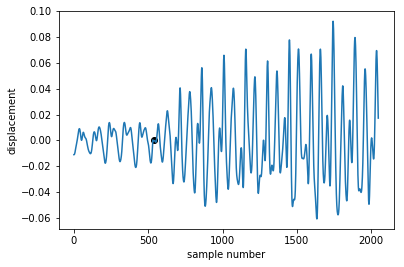

In [10]:
s = signal[int(0.5*44100):int(0.5*44100)+2048]
plt.plot(s)
plt.scatter([537],[0.],color="k")
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

# finding the optimal start time

In [32]:
# defining constants and range
period_prev = 79

a = 1
b = 0.01

time_plot_start = 500 # try 0
time_plot_end = 700 # try 2000
time_plot_range = time_plot_end - time_plot_start
period_plot_start = 80 # try 0
period_plot_end = 200 # try 100
period_plot_range = period_plot_end - period_plot_start

X = np.arange(time_plot_start, time_plot_end, 1)
Y = np.arange(period_plot_start, period_plot_end, 1)

In [33]:
# to be optimised, posted question here: https://www.reddit.com/r/learnpython/comments/79624o/optimizing_iterated_sums/

Z_ = np.zeros((time_plot_range, period_plot_range))

for x in X:
    print x,
    x_ = x - time_plot_start
    for y in Y:

        y_ = y - period_plot_start
        Z_[x_][y_] = (
            a*(np.sum([(s[t] - s[t + period_prev])**2 for t in range(0,x-period_prev)])) +
#             b*(np.sum([(s[t])**2 for t in range(0,x)])) +
            a*(np.sum([(s[t] - s[t + y])**2 for t in range(x,n-y)])) +
#             b*(np.sum([(s[t])**2 for t in range(x,n)])) +
            0.0
        )

500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699


## plotting $f(t_1,p_1)$

In [34]:
# orienting the graph to plot correctly

Z = np.transpose(Z_)
position = np.array(np.unravel_index(Z.argmin(), Z.shape))

time_minimum = time_plot_start + position[1]
freq_minimum = period_plot_start + position[0]

Z = np.flip(Z, 0)

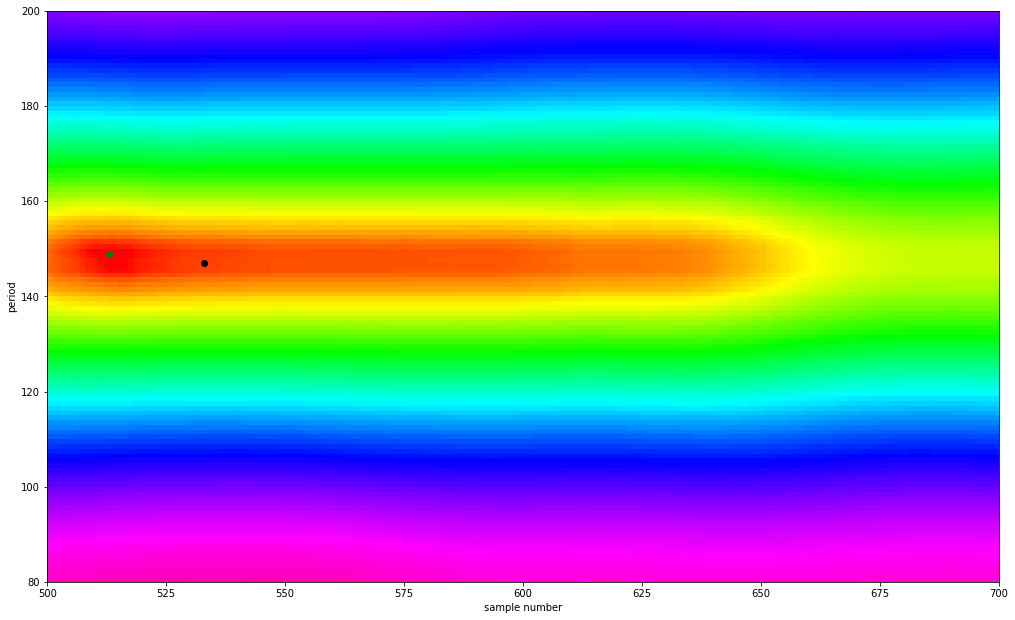

In [35]:
# changing the axis values: 
# https://stackoverflow.com/questions/18696122/change-values-on-matplotlib-imshow-graph-axis
# make 2d plot pixelated instead smooth 
# https://stackoverflow.com/questions/6323737/make-a-2d-pixel-plot-with-matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors

# plot
# x-axis is time, y-axis is period
# more (dark) red means smaller
img = plt.imshow(Z, cmap=cm.gist_rainbow, 
                 extent=[time_plot_start, time_plot_end, period_plot_start, period_plot_end], 
                 norm=colors.PowerNorm(gamma=1./2.))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.scatter([real_start_time],[real_period], color="k")
plt.scatter([time_plot_start + position[1]], [period_plot_start + position[0]], color="g")
plt.xlabel("sample number")
plt.ylabel("period")
plt.show()

In [36]:
print("range of values: {} - {}".format(np.min(Z),np.max(Z)))
print("time minimum {}".format(time_minimum))
print("freq minimum {}".format(freq_minimum))

range of values: 61.026339661 - 313.098562202
time minimum 513
freq minimum 149


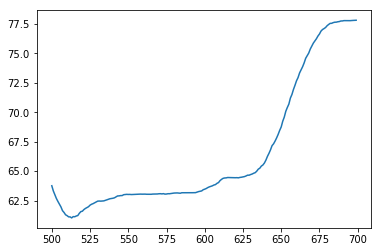

In [37]:
# horizontal slice across minimumm, to show time
plt.plot(np.arange(time_plot_start, time_plot_end, 1), 
         Z[period_plot_end-period_plot_start-position[0]-1,:])
plt.show()

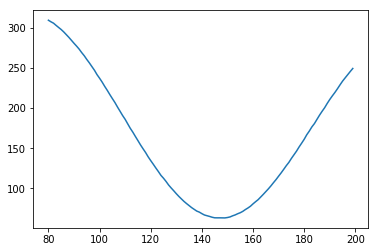

In [38]:
# vertical slice across minimum, to show pitch
plt.plot(np.arange(period_plot_start, period_plot_end, 1),
         (Z[:,position[0]])[::-1])
plt.show()